Analyses the scraped database of EPA Victoria, which goes back to 2000.

In [1]:
## Libraries
import requests
from bs4 import BeautifulSoup, Tag
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import networkx as nx
import math
import urllib
import seaborn as sns
import datetime
import plotly.express as px
import plotly.graph_objects as go

from requests_html import AsyncHTMLSession
from requests_html import HTMLSession

import scatterDF

In [22]:
df = pd.read_csv('CSVs/EPA_Victoria_Court_Proceedings_2000_to_2021728.csv')
pd.set_option('display.max_colwidth', None)


# streamline courts
df['Court location'] = df['Court location'].apply(lambda x:x.replace("’","'"))
df['Court location'] = df['Court location'].apply(lambda x:x.replace(" Magistrates' Court",""))
df['Court location'] = df['Court location'].apply(lambda x:x.replace("County Court of Victoria at ",""))
df['Court location'] = df['Court location'].apply(lambda x:x.replace("County Court of Victoria","Melbourne"))
df['Court location'] = df['Court location'].apply(lambda x:x.replace("County Court (sitting at Shepparton)","Shepparton"))
df['Court location'] = df['Court location'].apply(lambda x:x.replace(" County Court",""))
df['Court location'] = df['Court location'].apply(lambda x:x.replace("Not applicable.","Not applicable"))
df['Court location'] = df['Court location'].apply(lambda x:x.replace("Select a court location","Not applicable"))
df['Court location'] = df['Court location'].apply(lambda x:x.replace("Not applicable","Not stated"))

# cleanup magistrates
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:str(x))
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:x.replace("Mr",""))
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:x.replace("Ms",""))
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:x.replace("Magistrate ",""))
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:x.replace(".",""))
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:x.replace("His Honour",""))
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:x.replace("Judge",""))
df['Court magistrate'] = df['Court magistrate'].apply(lambda x:x.strip())

df.head(1)

Year  \
0  2000   

                                                                                                   URL  \
0  https://www.epa.vic.gov.au/about-epa/public-registers/court-proceedings/pj-and-iw-gillespie-pty-ltd   

                          Stub                   Offender  \
0  pj-and-iw-gillespie-pty-ltd  PJ & IW Gillespie Pty Ltd   

                                                                                                                                Type of offence  \
0  Dump industrial waste at a site not licensed to accept industrial waste contrary to section 27A(2)(a) of the Environment Protection Act 1970   

  Date of court hearing Date of court order Court magistrate Court location  \
0     15 September 2000   15 September 2000         Cashmore  Bacchus Marsh   

                                     Court orders made Date of offence  \
0  Without conviction, fined \$2,000 Costs: \$ 1006.50             NaN   

  Proceeding number Background of offense Remedial action taken by EPA  \
0               NaN                   NaN                          NaN   

  Reasons for prosecution  Total ($) Payments mentioned  section  \
0                     NaN     3006.5   [2000.0, 1006.5]  ['27A']   

      subsection Conviction  
0  ['27A(2)(a)']    Without

### MOST PROSECUTED CRIMES
### by SUBSECTION

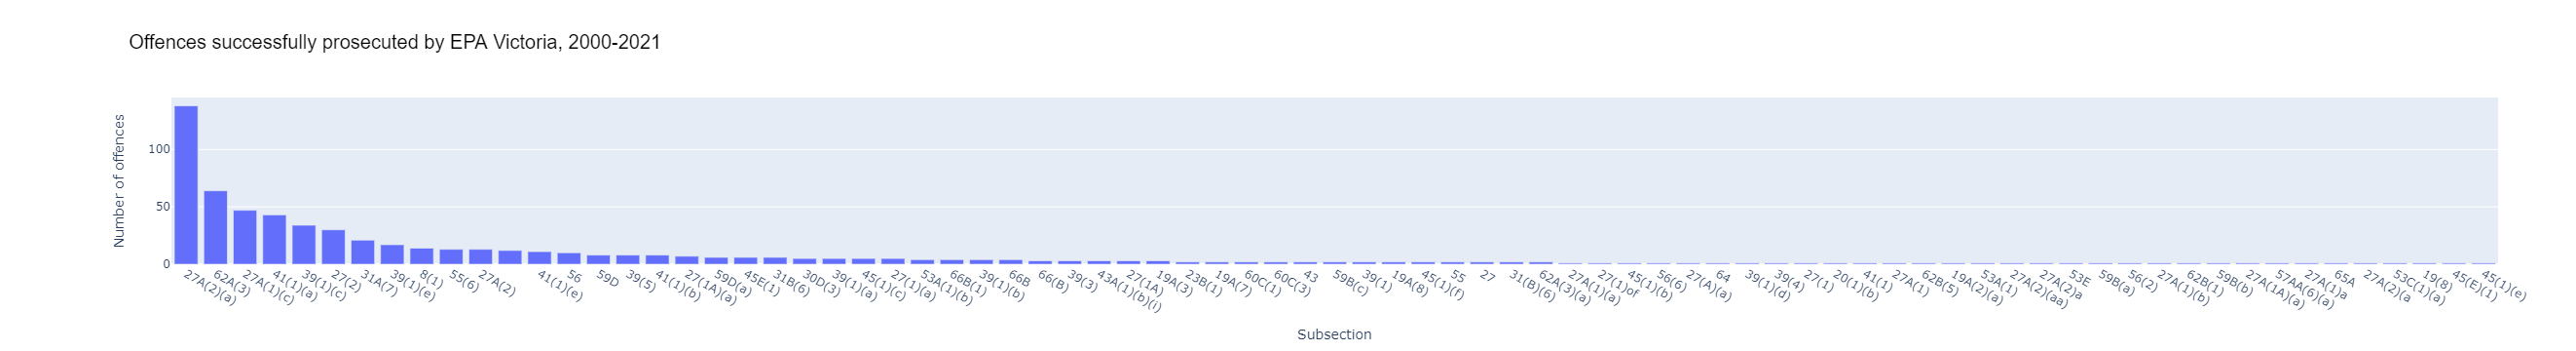

In [5]:
sss = []
for x in df['subsection']:
    x = x.replace('[','').replace(']','').replace("'",'').split(',')
    for y in x:
        sss.append(y.strip())        
sss = pd.Series(sss)

most_common_offences = sss.value_counts().index   ### used later

df_mco = pd.DataFrame(columns=['Subsection', 'Number of offences'])
df_mco['Subsection'] = sss.value_counts().index
df_mco['Number of offences'] = sss.value_counts().values

fig = px.bar(df_mco, x='Subsection', y='Number of offences', title="Offences successfully prosecuted by EPA Victoria, 2000-2021")

fig.update_layout(titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))

fig.show()
fig.write_html("test.html")

## ...and year

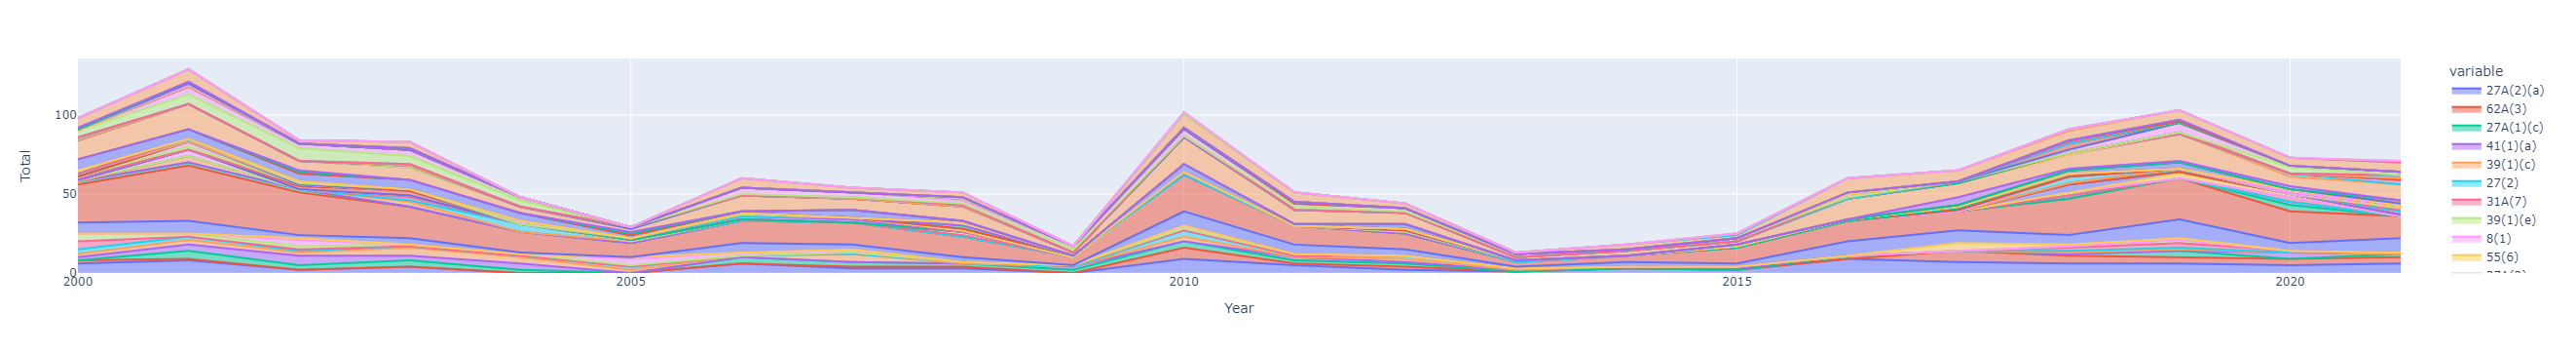

In [6]:
dfx = df[['Date of court order', 'subsection']].copy()
dfx['Year'] = dfx['Date of court order'].apply(lambda x:x[-4:])

df_oby = pd.DataFrame(columns=most_common_offences.insert(0,'Year'))
df_oby['Year'] = range(int(min(list(dfx['Year']))), 1 + int(max(list(dfx['Year']))))


def offencesByYear():

    for offence in most_common_offences:
        dfx[offence] = dfx['subsection'].str.contains(offence.replace('(','\(').replace(')','\)'))

        dfx1 = dfx.loc[dfx[offence] == True][['Year',offence]]
        dfx1 = dfx1.groupby(['Year']).count()

        #print(dfx1.index, dfx1.values)
                
        for n, i in enumerate(dfx1.index):
            df_oby.loc[df_oby["Year"] == int(dfx1.index[n]), offence] = dfx1.values[n][0]
    
offencesByYear()

df_oby = df_oby.fillna(0)
df_oby = df_oby.set_index('Year')


# filter to subsections with more than 20 offences in total
#df_oby = df_oby[df_oby.columns[df_oby.sum()>20]]

fig = px.area(df_oby, x=df_oby.index, y=df_oby.columns)

fig.update_yaxes(title_text='Total')

fig.show()
fig.write_html("test2.html")

### by SECTION

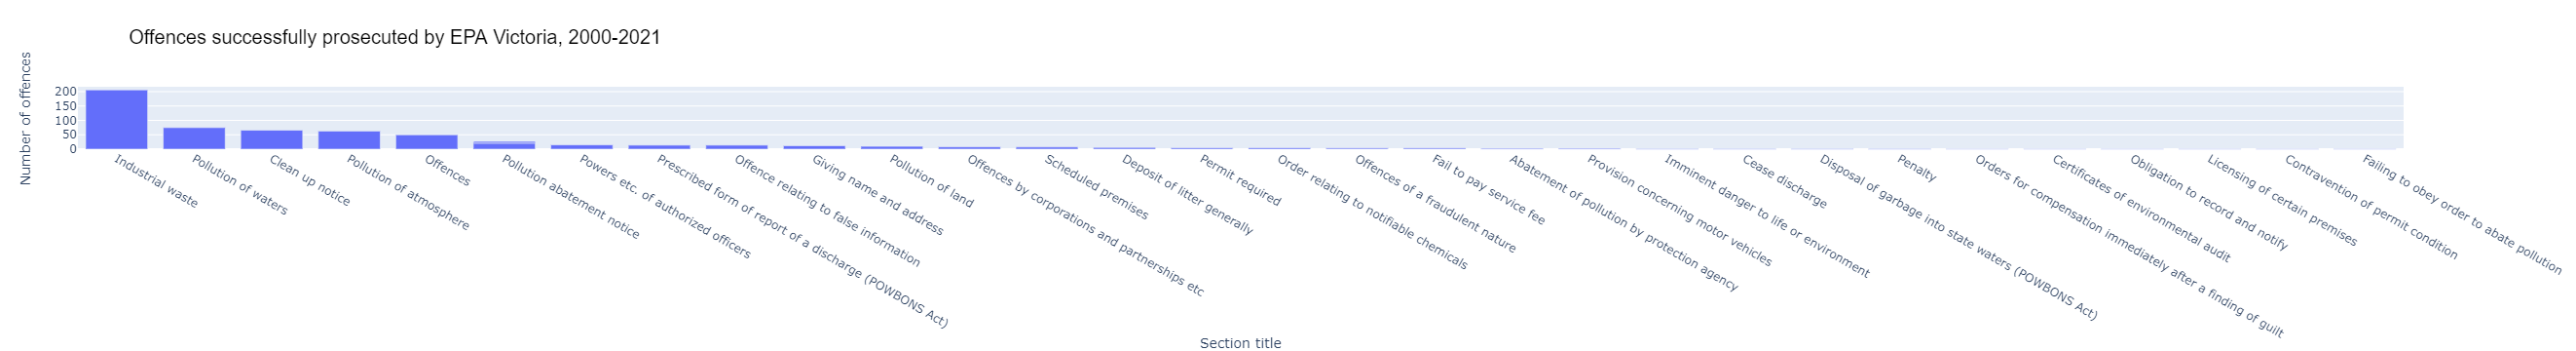

In [8]:
df_sections = pd.read_csv('sections.csv', header=None)
df_sections = df_sections.rename({0:'Section number', 1: 'Section title'}, axis='columns')

sss = []
for x in df['section']:
    x = x.replace('[','').replace(']','').replace("'",'').split(',')
    for y in x:
        
        if len(y) > 0:
        
            y = y.strip()
        
            if y[0] == '0':
                y = y[1:]

            #try:
            #    x = df_sections.loc[df_sections['Section number'] == y, 'Section title'].values[0].strip()  
            #except:
            #    x = 'X'
            #sss.append(x.strip())
            
            sss.append(y.strip())
            
sss = pd.Series(sss)

most_common_offences = sss.value_counts().index

df_mco = pd.DataFrame(columns=['Section', 'Number of offences'])
df_mco['Section'] = sss.value_counts().index
df_mco['Number of offences'] = sss.value_counts().values



# Renaming column
for s in df_mco['Section']:
    try:
        new_s = df_sections.loc[df_sections['Section number'] == s, 'Section title'].values[0].strip()
    except:
        new_s = s
        
    df_mco.loc[df_mco['Section'] == s, 'Section title'] = new_s
    

    
fig = px.bar(df_mco, x='Section title', y='Number of offences', title="Offences successfully prosecuted by EPA Victoria, 2000-2021")
fig.update_layout(titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))
fig.show()
fig.write_html("test.html")

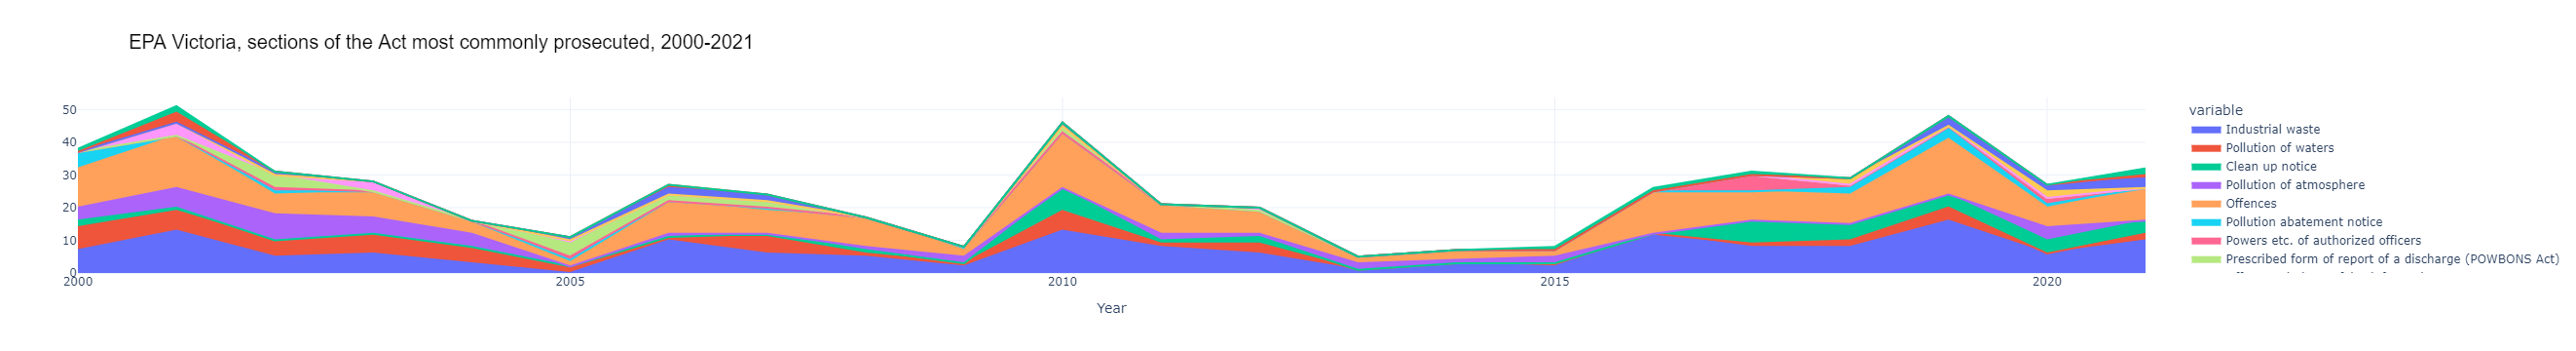

In [10]:
dfx = df[['Date of court order', 'section']].copy()
dfx['Year'] = dfx['Date of court order'].apply(lambda x:x[-4:])

df_oby = pd.DataFrame(columns=most_common_offences.insert(0,'Year'))
df_oby['Year'] = range(int(min(list(dfx['Year']))), 1 + int(max(list(dfx['Year']))))

def offencesByYear():

    for offence in most_common_offences:
        dfx[offence] = dfx['section'].str.contains(offence.replace('(','\(').replace(')','\)'))

        dfx1 = dfx.loc[dfx[offence] == True][['Year',offence]]
        dfx1 = dfx1.groupby(['Year']).count()

        #print(dfx1.index, dfx1.values)
                
        for n, i in enumerate(dfx1.index):
            df_oby.loc[df_oby["Year"] == int(dfx1.index[n]), offence] = dfx1.values[n][0]
    
offencesByYear()

df_oby = df_oby.fillna(0)
df_oby = df_oby.set_index('Year')  



# Renaming column
for s in df_oby.columns:
    
    try:
        new_s = df_sections.loc[df_sections['Section number'] == s, 'Section title'].values[0].strip()
    except:
        new_s = 'NA'
            
    df_oby = df_oby.rename({s:new_s},axis='columns')
    
df_oby = df_oby.iloc[:, : 13]   ### why am i needing to put this in?


fig = px.area(df_oby, x=df_oby.index, y=df_oby.columns, title='EPA Victoria, sections of the Act most commonly prosecuted, 2000-2021')

fig.update_yaxes(title_text='Total')

fig.for_each_trace(lambda trace: trace.update(fillcolor = trace.line.color))
fig.update_yaxes(title=None, visible=True, showticklabels=True)
fig.update_layout(titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))
fig.update_layout(template="plotly_white")

fig.show()
fig.write_html("EPA_Prosecutions_bySection_byYear.html")  

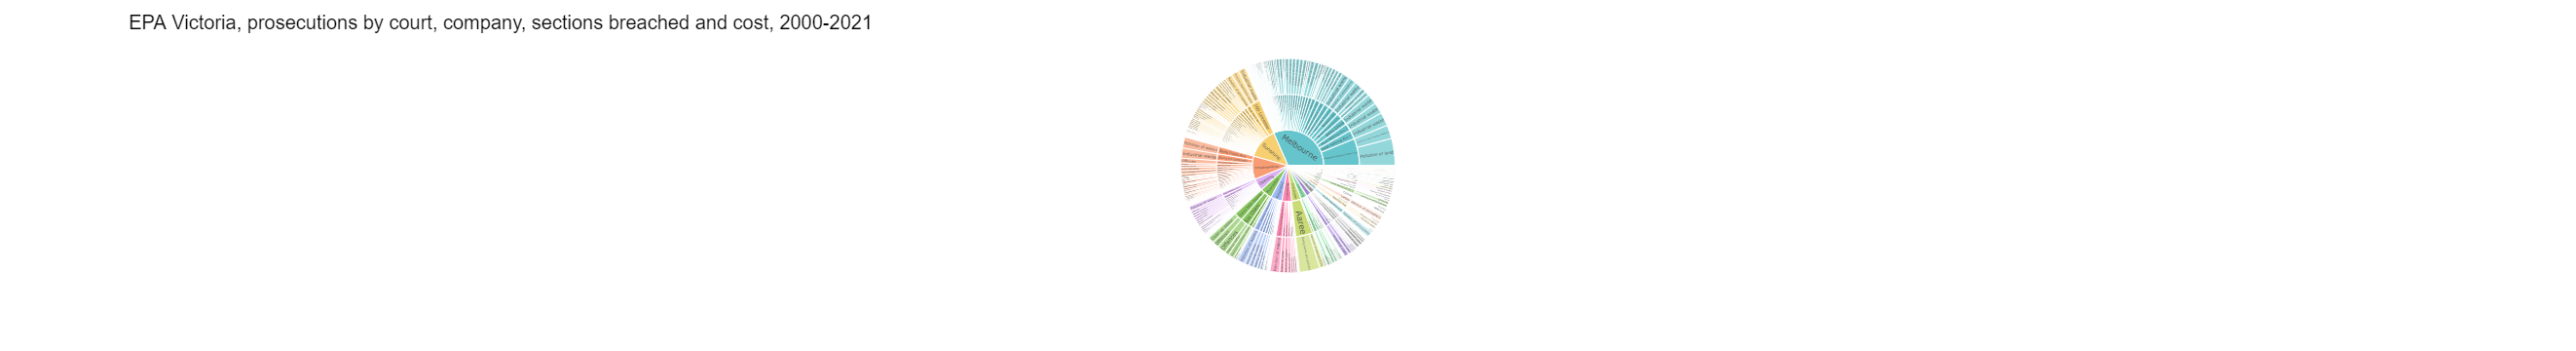

In [11]:
### STAR*BURST ###

df_sb = df.copy()
df_sb['Stub'] = df_sb['Stub'].apply(lambda x:x.replace('-',' ').title()) 

#df_sections = pd.read_csv('sections.csv', header=None)
#df_sections = df_sections.rename({0:'Section number', 1: 'Section title'}, axis='columns')

df_sb = df_sb[['URL', 'Court location', 'Stub', 'section', 'Total ($)', 'Date of court order']]

# streamline courts
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace("’","'"))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace(" Magistrates' Court",""))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace("County Court of Victoria at ",""))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace("County Court of Victoria","Melbourne"))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace("County Court (sitting at Shepparton)","Shepparton"))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace(" County Court",""))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace("Not applicable.","Not applicable"))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace("Select a court location","Not applicable"))
df_sb['Court location'] = df_sb['Court location'].apply(lambda x:x.replace("Not applicable","Not stated"))

df_sb2 = pd.DataFrame()

for index, row in df_sb.iterrows():
    ss = row['section'].replace('[','').replace(']','').replace("'",'').split(',')
    number_of_breaches = len(ss)
    location = row['Court location']
    stub = row['Stub'].replace('_','').replace('Pty','').replace('Ltd','').replace('Gmbh And Co','').replace('Australia','Aus').replace('  ',' ').strip()
    url = row['URL']
    date_court_orders = row['Date of court order']
    
    cost_total = row['Total ($)'] 
    cost_per_breach = cost_total / number_of_breaches
    
    for s in ss:               
        try:
            new_s = df_sections.loc[df_sections['Section number'] == s.strip(), 'Section title'].values[0].strip()
        except:
            news_s = 'n/a'
        
        next_row = df_sb2.shape[0]
        df_sb2.loc[next_row,'URL'] = url
        df_sb2.loc[next_row,'Court location'] = location
        df_sb2.loc[next_row, 'Stub'] = stub
        df_sb2.loc[next_row, 'Section'] = new_s
        df_sb2.loc[next_row, 'Cost total'] = cost_total
        df_sb2.loc[next_row, 'Cost per breach'] = cost_per_breach
        df_sb2.loc[next_row, 'Date of court orders'] = date_court_orders
        
        
fig = px.sunburst(df_sb2, path=['Court location', 'Stub', 'Section'], values='Cost per breach', 
                  color_discrete_sequence=px.colors.qualitative.Pastel, 
                 custom_data=['Stub', 'Cost total', 'Date of court orders', 'URL'])

fig.update_traces(
    hovertemplate="<br>".join([
        "%{customdata[0]}",
        "%{customdata[2]}",
        "Total payment: $%{customdata[1]}",
        "",
        "%{customdata[3]}",
    ])
)

fig.update_layout(title='EPA Victoria, prosecutions by court, company, sections breached and cost, 2000-2021')
fig.update_layout(titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))


fig.update_layout(template="plotly_white")

fig.show()

fig.write_html("EPA_Prosecutions_Sunburst.html")  

## With/without conviction

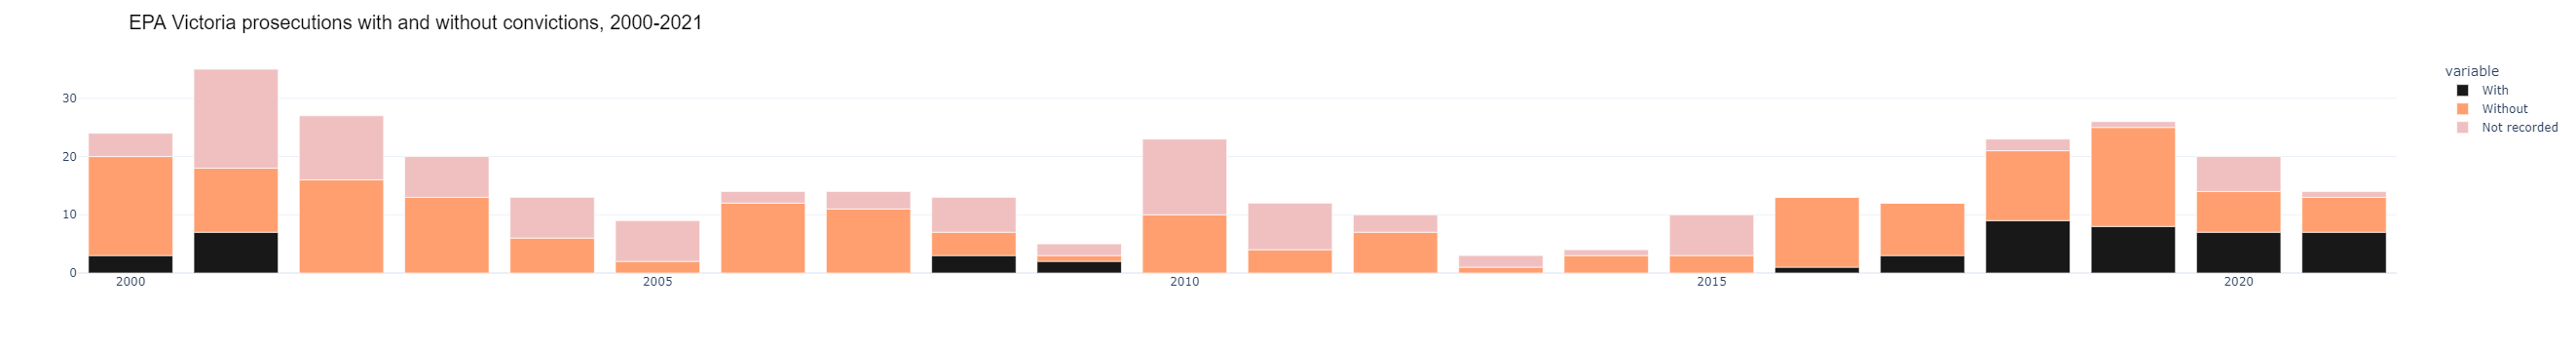

In [12]:
x = df.copy()
x['Conviction'] = x['Conviction'].fillna('Not recorded')
x = x[['Year','Conviction', 'Stub']].groupby(by=["Year", 'Conviction'], as_index=False).count()
x2 = pd.DataFrame()
x2['Year'] = list(set(x['Year']))

for c in ['With', 'Without', 'Not recorded']:
    for index, row in x.loc[x['Conviction'] == c].iterrows(): 
        x2.loc[x2['Year'] == row['Year'], c] = row['Stub']
x2 = x2.fillna(0)


fig = px.bar(x2, x='Year', y=['With', 'Without', 'Not recorded'], color_discrete_sequence=["#181818", "#FF9F70", "#F0c0c0"],)
fig.update_layout(title="EPA Victoria prosecutions with and without convictions, 2000-2021", titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))
fig.update_yaxes(title=None, visible=True, showticklabels=True)
fig.update_xaxes(title=None, visible=True, showticklabels=True)

fig.update_layout(template="plotly_white")

fig.show()
fig.write_html("EPA_Vic_prosecutions_and_convictions.html")


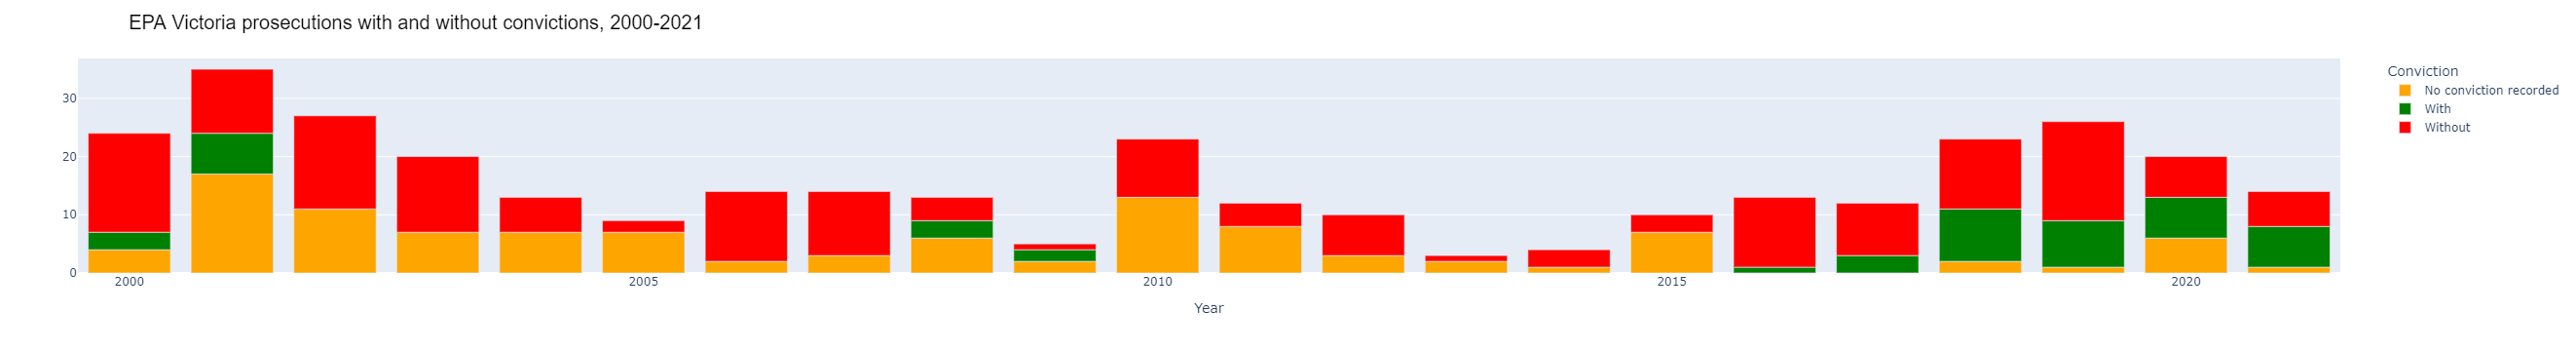

In [13]:
x = df.copy()
x['Conviction'] = x['Conviction'].fillna('No conviction recorded')
x = x[['Year','Conviction', 'Stub']].groupby(by=["Year", 'Conviction'], as_index=False).count()

fig = px.bar(x, x='Year', y='Stub', color='Conviction',  color_discrete_sequence=["orange", "green", "red"],)
fig.update_layout(title="EPA Victoria prosecutions with and without convictions, 2000-2021", titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))
fig.update_yaxes(title=None, visible=True, showticklabels=True)

fig.show()
fig.write_html("EPA_Vic_prosecutions_and_convictions2.html")

### SCATTERS: ProsecutionsXConvictions by Court, Magistrate and Year

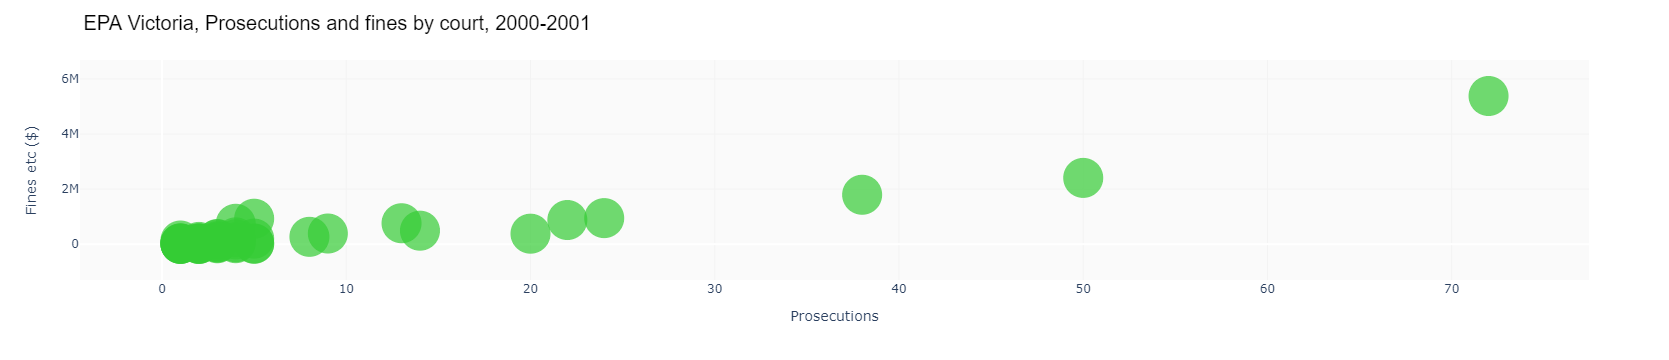

In [48]:
df_scatter = scatterDF.scatterDF(df, 'Court location', 'Total ($)')

# SCATTER Prosectution x Costs

fig = px.scatter(df_scatter, x='Number of', y='Total ($)', hover_name="Court location", )

fig.update_layout(paper_bgcolor='#ffffff', plot_bgcolor='#FAFAFA').update_traces(marker=dict(color='#33cc33'))
fig.update_layout(title='EPA Victoria, Prosecutions and fines by court, 2000-2001', titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))
fig.update_xaxes(title='Prosecutions', visible=True, showticklabels=True, gridcolor='#F3F3F3')
fig.update_yaxes(title='Fines etc ($)', visible=True, showticklabels=True, gridcolor='#F3F3F3')
fig.update_traces(marker=dict(size=40, opacity=0.7, line=dict(width=0, color='#181818')), selector=dict(mode='markers'))

fig.show()
fig.write_html("EPA_Vic_courts_prosecutionsXconvictions.html")

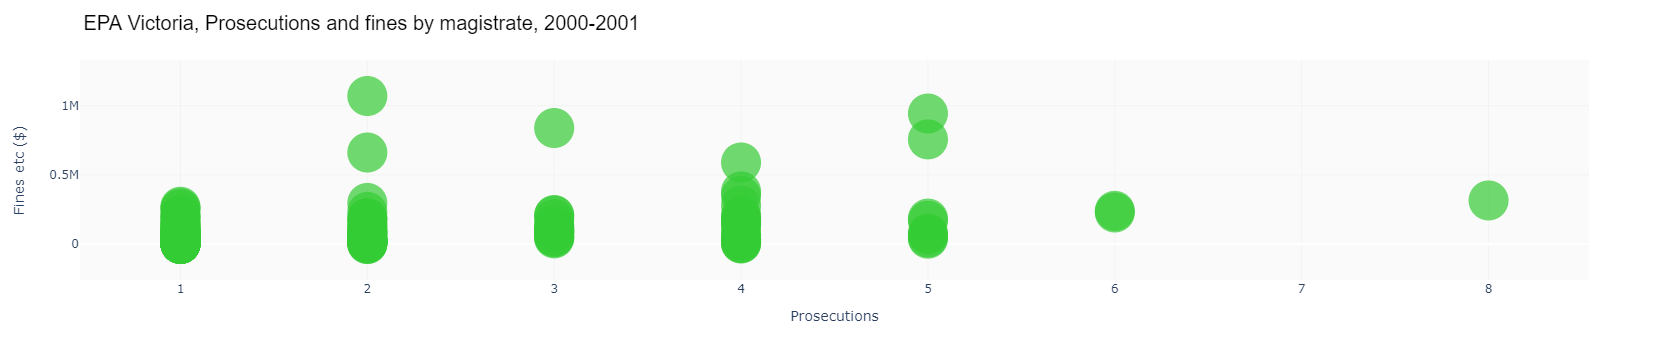

In [49]:
df_scatter = scatterDF.scatterDF(df, 'Court magistrate', 'Total ($)')

# SCATTER Prosectution x Costs

fig = px.scatter(df_scatter, x='Number of', y='Total ($)', hover_name="Court magistrate", )

fig.update_layout(paper_bgcolor='#ffffff', plot_bgcolor='#FAFAFA').update_traces(marker=dict(color='#33cc33'))
fig.update_layout(title='EPA Victoria, Prosecutions and fines by magistrate, 2000-2001', titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))
fig.update_xaxes(title='Prosecutions', visible=True, showticklabels=True, gridcolor='#F3F3F3')
fig.update_yaxes(title='Fines etc ($)', visible=True, showticklabels=True, gridcolor='#F3F3F3')
fig.update_traces(marker=dict(size=40, opacity=0.7, line=dict(width=0, color='#181818')), selector=dict(mode='markers'))

fig.show()
fig.write_html("EPA_Vic_magistrates_prosecutionsXconvictions.html")

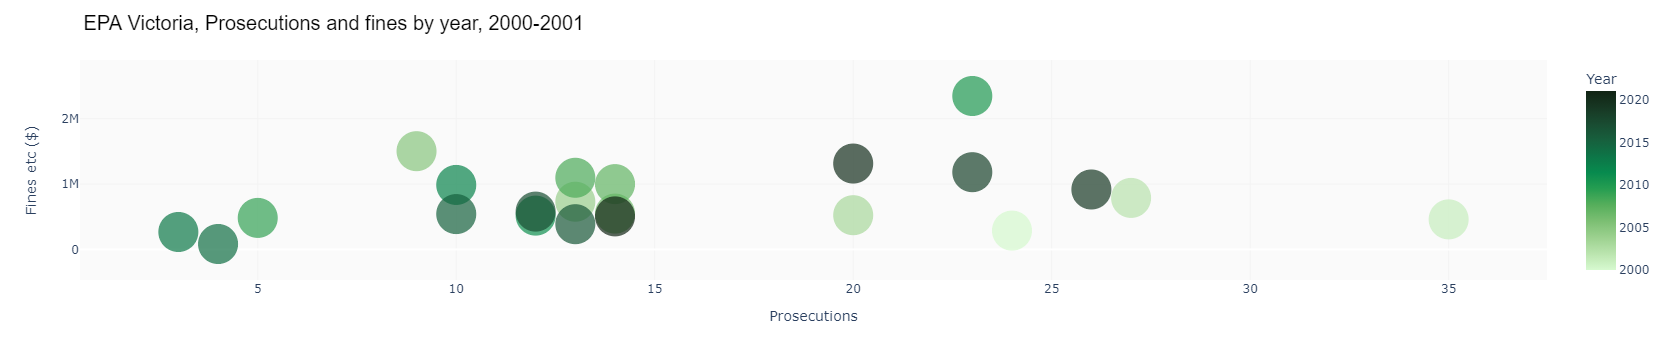

In [50]:
df_scatter = scatterDF.scatterDF(df, 'Year', 'Total ($)')

# SCATTER Prosectution x Costs

fig = px.scatter(df_scatter, x='Number of', y='Total ($)', hover_name="Year", color="Year", color_continuous_scale=px.colors.sequential.algae)

fig.update_layout(paper_bgcolor='#ffffff', plot_bgcolor='#FAFAFA') #.update_traces(marker=dict(color='#33cc33'))
fig.update_layout(title='EPA Victoria, Prosecutions and fines by year, 2000-2001', titlefont=dict(size = 20, color='black', family='Arial, sans-serif'))
fig.update_xaxes(title='Prosecutions', visible=True, showticklabels=True, gridcolor='#F3F3F3')
fig.update_yaxes(title='Fines etc ($)', visible=True, showticklabels=True, gridcolor='#F3F3F3')
fig.update_traces(marker=dict(size=40, opacity=0.7, line=dict(width=0, color='#181818')), selector=dict(mode='markers'))

fig.show()
fig.write_html("EPA_Vic_year_prosecutionsXconvictions.html")